# ME 395 Homework 4.1


- Given a combined guitar and drum sound, find the appropriate filter for a low pass filter and separate the drum sound only.
- Bonus: Design a high pass filter to filter and separate the guitar sound only.

Explain your understanding of how you have designed the filter and why the output is different than the provided input audio.

In [1]:
# imports
from scipy.io import wavfile
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt

# load data
sampling_rate, data = wavfile.read("guitar_drum.wav")
data_l = data[:, 0]
data_r = data[:, 1]
time = np.arange(0, len(data_l) / sampling_rate, 1 / sampling_rate)

C:\Users\kleme\AppData\Local\Temp\ipykernel_7536\108605982.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read("guitar_drum.wav")


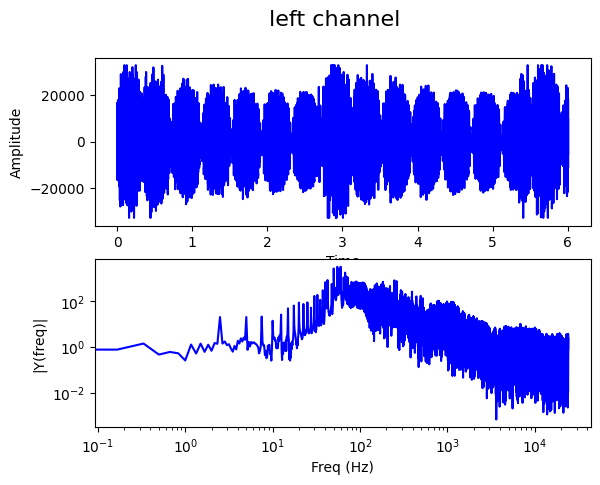

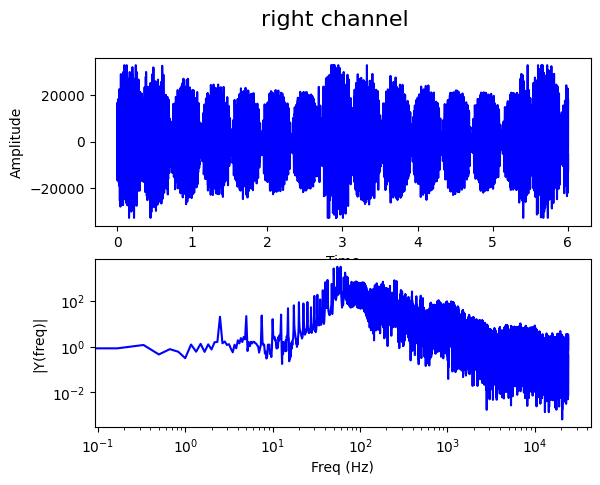

In [2]:
def plot_fft(t,y,frq,Y,title = None):
    """
    Plots signal over time as well as frequency spectrum over frequency range.
    Inputs:
        t (time as list), 
        data (signal data as list)
        frq (one side frequency range of signal), 
        Y (fft of signal)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    ax1.plot(t,y,'b')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax2.loglog(frq,abs(Y),'b') # plotting the fft
    ax2.set_xlabel('Freq (Hz)')
    ax2.set_ylabel('|Y(freq)|')
    plt.show()

def fft(t, data):
    """
    Computes FFT of some given function.
    Inputs: 
        t (time as list), 
        data (signal data as list)
    Returns: 
        frq (one side frequency range of signal), 
        Y (fft of signal)
    """
    dt = t[-1] / len(t)
    Fs = 1/dt
    n = len(data) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range
    Y = np.fft.fft(data)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    return frq,Y

frq_l, Y_l = fft(time, data_l)
frq_r, Y_r = fft(time, data_r)
plot_fft(time, data_l, frq_l, Y_l,'left channel')
plot_fft(time, data_r, frq_r, Y_r,'right channel')

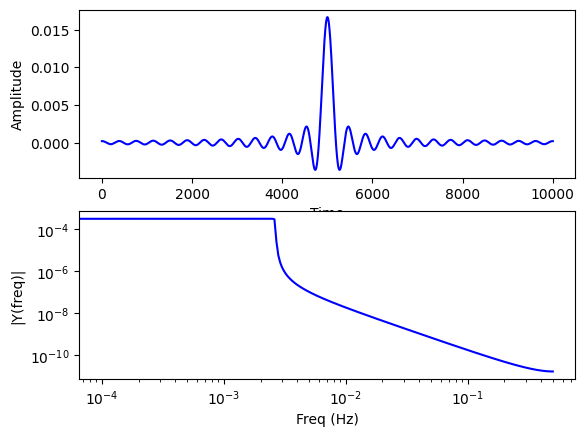

In [3]:
# using a SINC lowpass filter as seen in website below because Gaussian lowpass filter was hard to tune

def sinc(X: float) -> float:
    return 1.0 if X==0 else np.sin(X)/X

def lowpass_filter(length, sampling_rate, cutoff_freq = 65) -> np.ndarray:
    """https://tomroelandts.com/articles/how-to-create-a-simple-low-pass-filter"""
    cutoff_freq = cutoff_freq / sampling_rate
    filter = np.zeros((length,),dtype=float)
    for idx in range(length):
        filter[idx] = 2*cutoff_freq*sinc(2*cutoff_freq*(length/2-idx))
    return filter

filter_length = 10001
filter = lowpass_filter(filter_length, sampling_rate, cutoff_freq=400)

freq_filter, Y_filter = fft(range(filter_length), filter)
plot_fft(range(filter_length), filter, freq_filter, Y_filter)

Note: Frequency Axis in above plot does not match cutoff frequency (chosen as 400 Hz) because the time axis in the Amplitude plot is not time in seconds but rather discrete timesteps. Nevertheless, we can see the lowpass property of this filter.

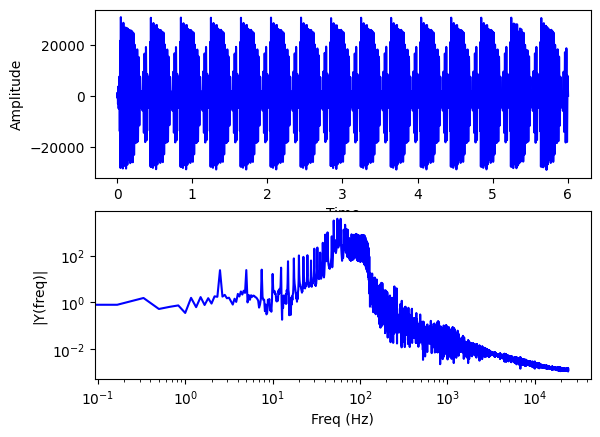

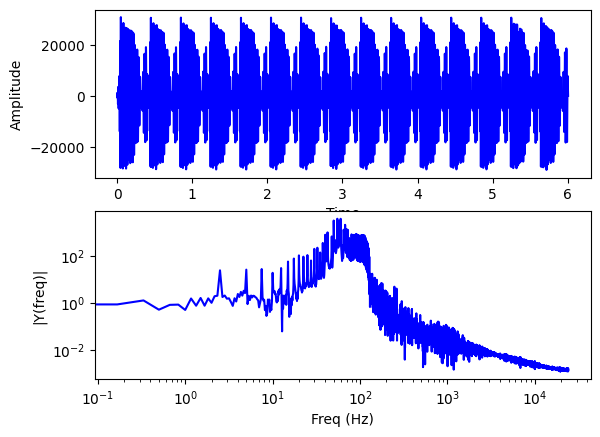

In [4]:
# perform lowpass filtering

lowpass = np.empty_like(data)

lowpass_l = signal.fftconvolve(data_l, filter, mode='same')
lowpass_r = signal.fftconvolve(data_r, filter, mode='same')
lowpass_l /= np.mean(np.abs(lowpass_l)) / np.mean(np.abs(data))
lowpass_r /= np.mean(np.abs(lowpass_r)) / np.mean(np.abs(data))

frq_low_l, Y_low_l = fft(time, lowpass_l)
plot_fft(time, lowpass_l, frq_low_l, Y_low_l)

frq_low_r, Y_low_r = fft(time, lowpass_r)
plot_fft(time, lowpass_r, frq_low_r, Y_low_r)

Comments: You can nicely see in the frequency plot that the lowpass filter has attenuated the frequencies larger than our cutoff-frequency 400 Hz. In fact, there already is a cutoff at around 100 Hz (due to rolloff).

In [5]:
lowpass = np.empty_like(data)
lowpass[:,0] = lowpass_l
lowpass[:,1] = lowpass_r
wavfile.write("guitar_drum_lowpass.wav", sampling_rate, lowpass.astype(np.int16))

Comment: We can hear in the audio file that the filter has removed the guitar sound and all we hear is the drum. However, the drums feel muffled (as if we were hearing the drums through a wall). 

The reason for this is due to applying the low-pass filter, we have removed all high frequences -- this not only removed the guitar sound, but also the highest frequencies of the drum sound, since the sharp "banging" of the drums is essentially a beat that also has high-frequency components.

## Bonus: High-Pass Filter

Performing high-pass filtering using spectral reversal (https://tomroelandts.com/articles/spectral-reversal-to-create-a-high-pass-filter)

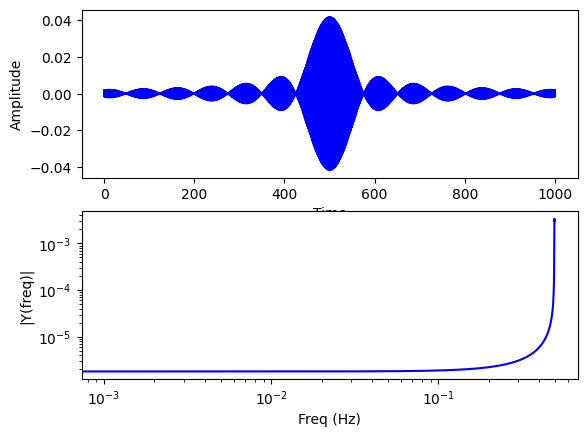

In [6]:
filter_length = 1001
filter_hp = lowpass_filter(filter_length, sampling_rate, cutoff_freq=1000)

for idx in range(filter_length):
    filter_hp[idx] *= (-1)**idx # FIX THIS

freq_filter, Y_filter = fft(range(filter_length), filter_hp)
plot_fft(range(filter_length), filter_hp, freq_filter, Y_filter)


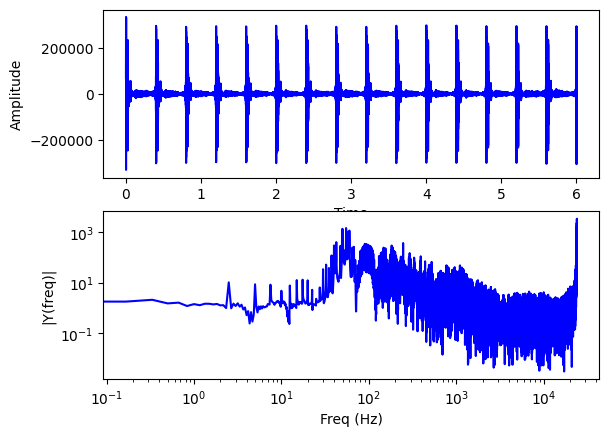

In [7]:
highpass = signal.fftconvolve(data_l, filter_hp, mode='same')
highpass /= np.mean(np.abs(highpass)) / np.mean(np.abs(data))

frq_high, Y_high = fft(time, highpass)
plot_fft(time, highpass, frq_high, Y_high)

wavfile.write("guitar_drum_highpass.wav", sampling_rate, highpass.astype(np.int16))


Note: Does not really work for some reason.